In [1]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from corner import corner
import torch
from torch import optim
import copy

In [2]:
import torch.nn.functional as F

from nflows.distributions.normal import StandardNormal
from nflows.flows.base import Flow
from nflows.transforms.autoregressive import MaskedAffineAutoregressiveTransform
from nflows.transforms.base import CompositeTransform
from nflows.transforms.normalization import BatchNorm
from nflows.transforms.permutations import RandomPermutation, ReversePermutation
from nflows.transforms.nonlinearities import Tanh
from nflows.transforms.standard import PointwiseAffineTransform
from nflows.transforms.base import InverseTransform


class MaskedAutoregressiveFlow(Flow):
    """An autoregressive flow that uses affine transforms with masking.
    Reference:
    > G. Papamakarios et al., Masked Autoregressive Flow for Density Estimation,
    > Advances in Neural Information Processing Systems, 2017.
    """

    def __init__(
        self,
        features,
        hidden_features,
        context_features=None,
        num_layers=1,
        num_blocks_per_layer=1,
        use_residual_blocks=True,
        use_random_masks=False,
        use_random_permutations=False,
        activation=F.relu,
        dropout_probability=0.,
        batch_norm_within_layers=False,
        batch_norm_between_layers=False,
    ):

        if use_random_permutations:
            permutation_constructor = RandomPermutation
        else:
            permutation_constructor = ReversePermutation

        layers = []
        layers.append(
            # InverseTransform(PointwiseAffineTransform(shift=.5, scale=.5)),
            PointwiseAffineTransform(shift=-1., scale=2.)
            )
        layers.append(InverseTransform(Tanh()))
        for _ in range(num_layers):
            layers.append(permutation_constructor(features))
            layers.append(
                MaskedAffineAutoregressiveTransform(
                    features=features,
                    hidden_features=hidden_features,
                    context_features=context_features,
                    num_blocks=num_blocks_per_layer,
                    use_residual_blocks=use_residual_blocks,
                    random_mask=use_random_masks,
                    activation=activation,
                    dropout_probability=dropout_probability,
                    use_batch_norm=batch_norm_within_layers,
                )
            )
            if batch_norm_between_layers:
                layers.append(BatchNorm(features))

        super().__init__(
            transform=CompositeTransform(layers),
            distribution=StandardNormal([features]),
        )

In [3]:
seed = 42
np.random.seed(seed)

In [4]:
def powerlaw(x, slope, lo, hi):
    
    return (
        (x >= lo) * (x <= hi)
        * x**slope
        * (slope+1) / (hi**(slope+1) - lo**(slope+1))
        )

def sample_powerlaw(n_samples, slope, lo, hi):
    
    x = np.random.uniform(size=n_samples)
    
    return (lo**(slope+1) + x * (hi**(slope+1) - lo**(slope+1)))**(1/(slope+1))

In [5]:
n_slopes = 10
n_train = 10000
n_valid = 10000

slopes_lo = 0
slopes_hi = 5
data_lo = 0
data_hi = 1
n_dim = 2

In [6]:
slopes_train = np.random.uniform(
    low=slopes_lo, high=slopes_hi, size=n_slopes,
    )
slopes_valid = np.random.uniform(
    low=slopes_lo, high=slopes_hi, size=n_slopes,
    )

data_train = sample_powerlaw(
    (n_slopes, n_train, n_dim),
    slopes_train[:, None, None],
    data_lo,
    data_hi,
    )
data_valid = sample_powerlaw(
    (n_slopes, n_valid, n_dim),
    slopes_valid[:, None, None],
    data_lo,
    data_hi,
    )

slopes_train.shape, slopes_valid.shape, data_train.shape, data_valid.shape

((10,), (10,), (10, 10000, 2), (10, 10000, 2))

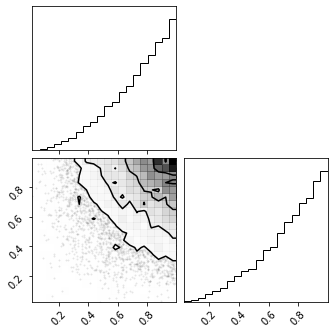

In [7]:
i = 0
corner(data_train[i]);

In [8]:
slopes_train = np.repeat(slopes_train[:, None, None], n_train, axis=1)
slopes_valid = np.repeat(slopes_valid[:, None, None], n_valid, axis=1)

slopes_train.shape, slopes_valid.shape

((10, 10000, 1), (10, 10000, 1))

In [9]:
slopes_train = slopes_train.reshape(-1, 1)
slopes_valid = slopes_valid.reshape(-1, 1)
data_train = data_train.reshape(-1, n_dim)
data_valid = data_valid.reshape(-1, n_dim)

slopes_train.shape, slopes_valid.shape, data_train.shape, data_valid.shape

((100000, 1), (100000, 1), (100000, 2), (100000, 2))

In [10]:
features = 2
context_features = 1
num_layers = 10
hidden_features = 1024
num_blocks_per_layer = 1
batch_norm_between_layers = True

epochs = 10
batch_size = 100
lr = 1e-4
weight_decay = 1e-6

In [11]:
flow = MaskedAutoregressiveFlow(
    features=features,
    context_features=context_features,
    num_layers=num_layers,
    hidden_features=hidden_features,
    num_blocks_per_layer=num_blocks_per_layer,
    batch_norm_between_layers=batch_norm_between_layers,
    )

optimizer = optim.Adam(
    flow.parameters(),
    lr=lr,
    weight_decay=weight_decay,
    )

In [39]:
train_context = torch.from_numpy(slopes_train.astype(np.float32))
train_features = torch.from_numpy(data_train.astype(np.float32))
train_dataset = torch.utils.data.TensorDataset(train_features, train_context)
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True,
    )

train_loader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(
        torch.as_tensor(data_train, dtype=torch.float32),
        torch.as_tensor(slopes_train, dtype=torch.float32),

In [40]:
best_valid_loss = np.inf
best_valid_epoch = 0
best_flow = flow

for epoch in range(epochs):
    print(epoch)
    
    flow.train(True)
    train_loss = 0.
    
    for batch_idx, data in enumerate(tqdm(train_loader)):
        
        x = data[0]
        y = data[1]
        
        optimizer.zero_grad()
        loss = -flow.log_prob(inputs=x, context=y).mean()
        train_loss += loss.item()
        loss.backward()
        optimizer.step()
        
    if train_loss < best_train_loss:
        best_train_loss = train_loss
        best_train_epoch = epoch
        best_flow = copy.deepcopy(flow)

0


100%|███████████████████████████████████████████████████████████| 1000/1000 [00:32<00:00, 31.02it/s]


1


100%|███████████████████████████████████████████████████████████| 1000/1000 [00:31<00:00, 31.62it/s]


2


100%|███████████████████████████████████████████████████████████| 1000/1000 [00:28<00:00, 35.45it/s]


3


100%|███████████████████████████████████████████████████████████| 1000/1000 [00:24<00:00, 40.08it/s]


4


100%|███████████████████████████████████████████████████████████| 1000/1000 [00:25<00:00, 39.21it/s]


5


100%|███████████████████████████████████████████████████████████| 1000/1000 [00:26<00:00, 37.71it/s]


6


100%|███████████████████████████████████████████████████████████| 1000/1000 [00:27<00:00, 37.02it/s]


7


100%|███████████████████████████████████████████████████████████| 1000/1000 [00:28<00:00, 35.55it/s]


8


100%|███████████████████████████████████████████████████████████| 1000/1000 [00:29<00:00, 33.86it/s]


9


100%|███████████████████████████████████████████████████████████| 1000/1000 [00:30<00:00, 33.14it/s]


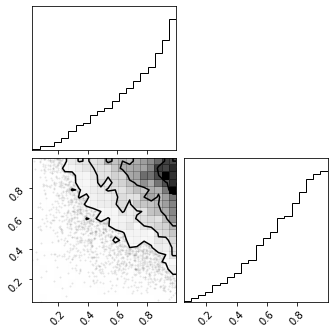

In [47]:
best_flow.train(False)
corner(best_flow.sample(10000, [[2.]]).detach().numpy()[0]);